In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
from torchvision.io import read_image
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
path = "/content/drive/MyDrive/cat__and_dog_breed_classification/Notebook/Images/"

In [4]:
test_annotation = open("annotations/annotations/test.txt").readlines()
train_annotation = open("annotations/annotations/trainval.txt").readlines()

In [5]:
#Make dictionary for our classes
class_id = []
label = []
for x in test_annotation:
    class_name = x.split(' ')[0].replace("_"," ")
    cleaned_name = ''.join([i for i in class_name if not i.isdigit()])
    class_id.append(cleaned_name.rstrip())
    label.append(int(x.split(' ')[1])-1)

class_names = pd.DataFrame(class_id,label).drop_duplicates().to_dict()[0]


In [6]:
class_names

{0: 'Abyssinian',
 1: 'american bulldog',
 2: 'american pit bull terrier',
 3: 'basset hound',
 4: 'beagle',
 5: 'Bengal',
 6: 'Birman',
 7: 'Bombay',
 8: 'boxer',
 9: 'British Shorthair',
 10: 'chihuahua',
 11: 'Egyptian Mau',
 12: 'english cocker spaniel',
 13: 'english setter',
 14: 'german shorthaired',
 15: 'great pyrenees',
 16: 'havanese',
 17: 'japanese chin',
 18: 'keeshond',
 19: 'leonberger',
 20: 'Maine Coon',
 21: 'miniature pinscher',
 22: 'newfoundland',
 23: 'Persian',
 24: 'pomeranian',
 25: 'pug',
 26: 'Ragdoll',
 27: 'Russian Blue',
 28: 'saint bernard',
 29: 'samoyed',
 30: 'scottish terrier',
 31: 'shiba inu',
 32: 'Siamese',
 33: 'Sphynx',
 34: 'staffordshire bull terrier',
 35: 'wheaten terrier',
 36: 'yorkshire terrier'}

In [19]:
#Make a custom image dataset class to load into PyTorch

class CustomImageDataset(Dataset):
    def __init__(self, annotations_list, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_list
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx].split(' ')[0] + '.jpg')
        #image = read_image(img_path)
        image = Image.open(img_path).convert('RGB')
        label = int(self.img_labels[idx].split(' ')[1]) - 1 
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [20]:
train_dataset = CustomImageDataset(annotations_list=train_annotation,img_dir= "images/images",transform=data_transforms['train'])
test_dataset = CustomImageDataset(annotations_list=test_annotation,img_dir="images/images",transform=data_transforms['val'])

image_datasets = {'train': train_dataset, 'val': test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Make our data loaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [21]:
inputs, classes = next(iter(train_dataloader))

In [22]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

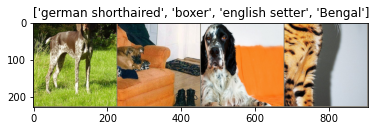

In [23]:
# Make a grid from batch and show some of the classes
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x.item()] for x in classes])

In [28]:
# Make batch size a bigger for training
# Make our data loaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

dataloaders = {'train': train_dataloader , 'val': val_dataloader}

In [35]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #print(labels)
                    loss = criterion(outputs, labels)
                    #print(loss)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [36]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5619 Acc: 0.8307
val Loss: 0.3910 Acc: 0.8866

Epoch 1/24
----------
train Loss: 0.5115 Acc: 0.8486
val Loss: 0.3809 Acc: 0.8913

Epoch 2/24
----------
train Loss: 0.4890 Acc: 0.8595
val Loss: 0.3751 Acc: 0.8872

Epoch 3/24
----------
train Loss: 0.4656 Acc: 0.8620
val Loss: 0.3741 Acc: 0.8899

Epoch 4/24
----------
train Loss: 0.4268 Acc: 0.8785
val Loss: 0.3559 Acc: 0.8956

Epoch 5/24
----------
train Loss: 0.4380 Acc: 0.8704
val Loss: 0.3549 Acc: 0.8940

Epoch 6/24
----------
train Loss: 0.4289 Acc: 0.8807
val Loss: 0.3537 Acc: 0.8940

Epoch 7/24
----------
train Loss: 0.4275 Acc: 0.8772
val Loss: 0.3499 Acc: 0.8972

Epoch 8/24
----------
train Loss: 0.4247 Acc: 0.8774
val Loss: 0.3497 Acc: 0.8953

Epoch 9/24
----------
train Loss: 0.4426 Acc: 0.8696
val Loss: 0.3502 Acc: 0.8948

Epoch 10/24
----------
train Loss: 0.4375 Acc: 0.8712
val Loss: 0.3529 Acc: 0.8953

Epoch 11/24
----------
train Loss: 0.4027 Acc: 0.8845
val Loss: 0.3487 Acc: 0.8972

Ep

In [39]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

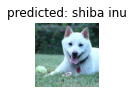

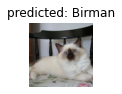

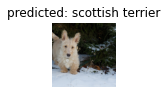

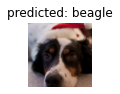

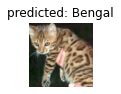

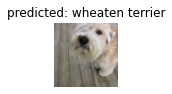

In [71]:
visualize_model(model_ft)

In [52]:
torch.save(model_ft.state_dict(), "model")

In [61]:
inputs, labels = next(iter(test_dataloader))
inputs.to(device)
labels.to(device)

tensor([14, 33, 24, 28], device='cuda:0')

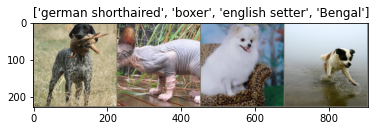

In [62]:
# Make a grid from batch and show some of the classes
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x.item()] for x in classes])

In [63]:
outputs = model_ft(inputs)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [60]:
inputs.shape

torch.Size([4, 3, 224, 224])